In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(1)
tf_determinism.enable_determinism()

tf.config.experimental.list_physical_devices('GPU')

fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
image_shape = (224, 224)
num_classes = 5
batch_size = 10
VAL_SPLIT = 0.2
IMG_SIZE = image_shape[0]

# train_data, val_data = keras.utils.image_dataset_from_directory(
#     'flower_images', 
#     batch_size=batch_size, 
#     image_size=image_shape, 
#     label_mode='categorical', 
#     seed=225, 
#     validation_split= 0.2, 
#     subset='both'
#     )

In [4]:
from data_loader import DataSet

dataset = DataSet(dataset_dir='flower_images')
train_data, val_data = dataset(validation_split=0.2)
val_ds = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_ds = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
data_augmentation = keras.Sequential([
    # keras.layers.Rescaling(scale=1./255.0, offset=0),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.20)
])

In [6]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    input = data_augmentation(input)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(input)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [7]:
model = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 512)  75776       ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 512)  0           ['conv2d[1][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 512)  2048       ['activation[1][0]']         

In [8]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-256-12-{epoch}.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [10]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_ds, epochs=50, batch_size=batch_size, validation_data=val_ds, callbacks=callbacks, verbose='auto')

Epoch 1/50
400/400 [==============================] - 180s 381ms/step - loss: 1.3308 - accuracy: 0.4955 - val_loss: 1.6379 - val_accuracy: 0.3080 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 160s 398ms/step - loss: 1.1681 - accuracy: 0.5530 - val_loss: 1.2035 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 162s 401ms/step - loss: 1.0956 - accuracy: 0.5965 - val_loss: 1.2031 - val_accuracy: 0.5170 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 162s 402ms/step - loss: 1.0149 - accuracy: 0.6308 - val_loss: 1.5646 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 163s 403ms/step - loss: 0.9711 - accuracy: 0.6410 - val_loss: 1.0260 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - 162s 403ms/step - loss: 0.9022 - accuracy: 0.6790 - val_loss: 1.1372 - val_accuracy: 0.5690 - lr: 0.0010
Epoch 7/50
400/400 [==========================

Text(0.5, 0.98, 'Loss and Accuracy with Normal Augmentation')

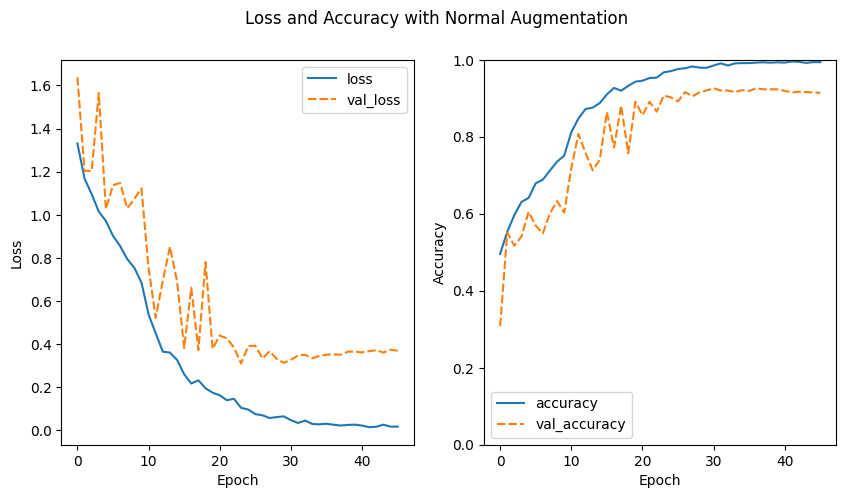

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, ax=axes[0])
ax.set(xlabel='Epoch', ylabel='Loss')
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}, ax=axes[1])
ax.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
plt.suptitle("Loss and Accuracy with Normal Augmentation")